In [1]:
# Import required libraries
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from collections import deque
import pickle
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')



In [2]:
# Initialize MediaPipe hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)
mp_drawing = mp.solutions.drawing_utils

print("MediaPipe initialized successfully!")


MediaPipe initialized successfully!


In [3]:
def collect_gesture_data(gesture_name, num_sequences=50, sequence_length=30):
    """
    Collect gesture data using webcam
    """
    cap = cv2.VideoCapture(0)
    
    # Create directory for this gesture
    data_path = os.path.join('gesture_data', gesture_name)
    os.makedirs(data_path, exist_ok=True)
    
    print(f"Collecting data for gesture: {gesture_name}")
    print(f"Will collect {num_sequences} sequences of {sequence_length} frames each")
    print("Instructions:")
    print("- Press 's' to start recording a sequence")
    print("- Press 'q' to quit")
    print("- Make sure your hand is visible in the frame")
    
    sequence = 0
    frame_num = 0
    collecting = False
    sequence_data = []
    
    while cap.isOpened() and sequence < num_sequences:
        ret, frame = cap.read()
        if not ret:
            break
            
        # Flip frame horizontally for mirror effect
        frame = cv2.flip(frame, 1)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Process frame with MediaPipe
        results = hands.process(rgb_frame)
        
        # Draw landmarks if hand is detected
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    frame, hand_landmarks, mp_hands.HAND_CONNECTIONS
                )
                
                # Extract landmarks (21 landmarks * 3 coordinates = 63 features)
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
                
                if collecting:
                    sequence_data.append(landmarks)
                    frame_num += 1
                    
                    # Display recording progress
                    cv2.putText(frame, f'RECORDING... Frame: {frame_num}/{sequence_length}', 
                              (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                    
                    if frame_num >= sequence_length:
                        # Save sequence
                        np.save(os.path.join(data_path, f'seq_{sequence}.npy'), sequence_data)
                        sequence += 1
                        frame_num = 0
                        sequence_data = []
                        collecting = False
                        
                        print(f"Sequence {sequence}/{num_sequences} saved")
                        
                        # Wait before next sequence
                        time.sleep(1)
        
        # Display instructions and status
        if not collecting:
            cv2.putText(frame, f'Press "s" to start sequence {sequence + 1}', 
                      (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        
        cv2.putText(frame, f'Gesture: {gesture_name} | Progress: {sequence}/{num_sequences}', 
                  (10, frame.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        cv2.imshow('Gesture Data Collection', frame)
        
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('s') and not collecting and results.multi_hand_landmarks:
            collecting = True
            frame_num = 0
            sequence_data = []
            print(f"Starting sequence {sequence + 1}")
    
    cap.release()
    cv2.destroyAllWindows()
    
    print(f"Data collection complete for '{gesture_name}'!")
    print(f"Collected {sequence} sequences")
    
    return sequence




In [4]:
# Define your gestures
gestures = ['kuzuzangpo', 'iLoveYou','peace',]

# Collect data for each gesture
collected_data = {}

for gesture in gestures:
    print(f"\n{'='*50}")
    print(f"Ready to collect data for: {gesture.upper()}")
    print(f"{'='*50}")
    
    input("Press Enter when ready to start...")
    
    num_collected = collect_gesture_data(gesture, num_sequences=100,sequence_length=30)
    collected_data[gesture] = num_collected
    
    print(f"Finished collecting {num_collected} sequences for '{gesture}'")

print("\nData Collection Summary:")
for gesture, count in collected_data.items():
    print(f"- {gesture}: {count} sequences")



Ready to collect data for: KUZUZANGPO
Will collect 100 sequences of 30 frames each
Instructions:
- Press 's' to start recording a sequence
- Press 'q' to quit
- Make sure your hand is visible in the frame
Starting sequence 1
Sequence 1/100 saved
Data collection complete for 'kuzuzangpo'!
Collected 1 sequences
Finished collecting 1 sequences for 'kuzuzangpo'

Ready to collect data for: ILOVEYOU
Will collect 100 sequences of 30 frames each
Instructions:
- Press 's' to start recording a sequence
- Press 'q' to quit
- Make sure your hand is visible in the frame
Data collection complete for 'iLoveYou'!
Collected 0 sequences
Finished collecting 0 sequences for 'iLoveYou'

Ready to collect data for: PEACE
Will collect 100 sequences of 30 frames each
Instructions:
- Press 's' to start recording a sequence
- Press 'q' to quit
- Make sure your hand is visible in the frame
Data collection complete for 'peace'!
Collected 0 sequences
Finished collecting 0 sequences for 'peace'

Data Collection Sum

Found gesture folders: ['iLoveYou', 'kuzuzangpo', 'peace']
Loading 89 sequences for 'iLoveYou'
Loading 100 sequences for 'kuzuzangpo'
Loading 100 sequences for 'peace'
Loaded data shape: (289, 30, 63)
Number of samples per gesture:
- iLoveYou: 89 samples
- kuzuzangpo: 100 samples
- peace: 100 samples


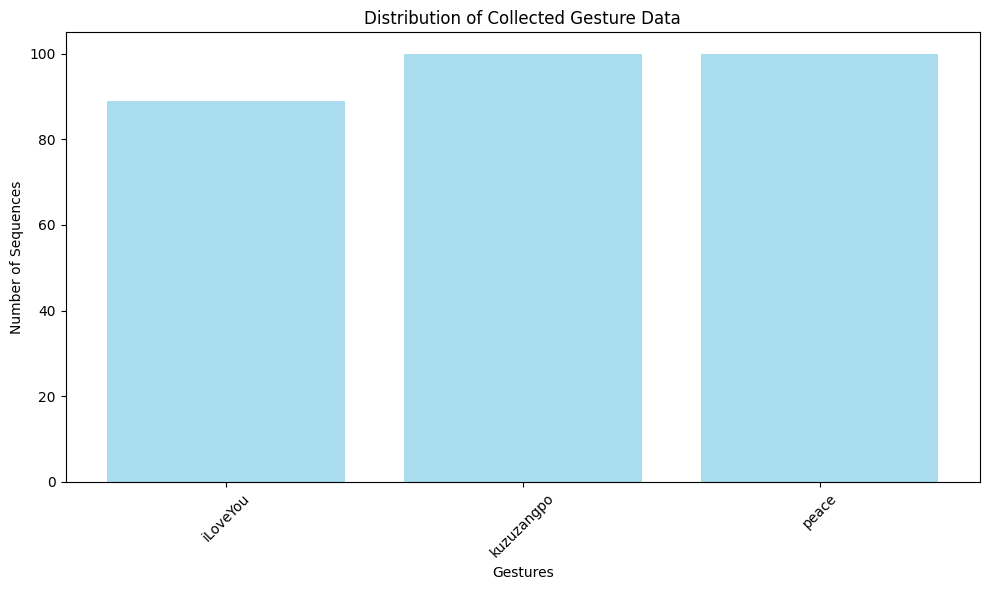

In [5]:
def load_collected_data():
    """
    Load all collected gesture data
    """
    sequences = []
    labels = []
    
    gesture_folders = [f for f in os.listdir('gesture_data') 
                      if os.path.isdir(os.path.join('gesture_data', f))]
    
    print(f"Found gesture folders: {gesture_folders}")
    
    for gesture in gesture_folders:
        gesture_path = os.path.join('gesture_data', gesture)
        sequence_files = [f for f in os.listdir(gesture_path) if f.endswith('.npy')]
        
        print(f"Loading {len(sequence_files)} sequences for '{gesture}'")
        
        for sequence_file in sequence_files:
            sequence_data = np.load(os.path.join(gesture_path, sequence_file))
            
            if len(sequence_data) == 30:  # Ensure correct sequence length
                sequences.append(sequence_data)
                labels.append(gesture)
    
    return np.array(sequences), np.array(labels)

# Load the data
X_raw, y_raw = load_collected_data()

print(f"Loaded data shape: {X_raw.shape}")
print(f"Number of samples per gesture:")
unique, counts = np.unique(y_raw, return_counts=True)
for gesture, count in zip(unique, counts):
    print(f"- {gesture}: {count} samples")

# Visualize data distribution
plt.figure(figsize=(10, 6))
plt.bar(unique, counts, color='skyblue', alpha=0.7)
plt.title('Distribution of Collected Gesture Data')
plt.xlabel('Gestures')
plt.ylabel('Number of Sequences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:
def normalize_landmarks(sequences):
    """
    Normalize hand landmarks relative to wrist position
    """
    normalized_sequences = np.copy(sequences)
    
    for i in range(len(sequences)):
        for j in range(len(sequences[i])):
            # Get wrist position (landmark 0: x, y coordinates)
            wrist_x, wrist_y = sequences[i][j][0], sequences[i][j][1]
            
            # Normalize all landmarks relative to wrist
            for k in range(0, len(sequences[i][j]), 3):
                normalized_sequences[i][j][k] -= wrist_x      # x coordinate
                normalized_sequences[i][j][k+1] -= wrist_y    # y coordinate
                # z coordinate stays the same (relative depth)
    
    return normalized_sequences

def preprocess_data(X, y):
    """
    Complete preprocessing pipeline
    """
    # Normalize landmarks
    X_normalized = normalize_landmarks(X)
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_normalized, y_categorical, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_encoded
    )
    
    return X_train, X_test, y_train, y_test, label_encoder

# Preprocess the data
X_train, X_test, y_train, y_test, label_encoder = preprocess_data(X_raw, y_raw)

print("Data preprocessing complete!")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")

# Save preprocessed data
os.makedirs('processed_data', exist_ok=True)
np.save('processed_data/X_train.npy', X_train)
np.save('processed_data/X_test.npy', X_test)
np.save('processed_data/y_train.npy', y_train)
np.save('processed_data/y_test.npy', y_test)

with open('processed_data/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("Preprocessed data saved!")


Data preprocessing complete!
Training set shape: (231, 30, 63)
Test set shape: (58, 30, 63)
Number of classes: 3
Classes: ['iLoveYou' 'kuzuzangpo' 'peace']
Preprocessed data saved!


In [ ]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [9]:
def build_lstm_model(input_shape, num_classes):
    """
    Build LSTM model for gesture recognition
    """
# Try a simpler model first:
    model = Sequential([
        LSTM(32, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
])

    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build the model
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, features)
num_classes = y_train.shape[1]

model = build_lstm_model(input_shape, num_classes)

# Display model architecture
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 32)         │        12,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,299 (153.51 KB)

 Trainable params: 39,299 (153.51 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Create callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        '.models/best_gesture_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=10,
        min_lr=0.0001,
        verbose=1
    )
]

# Train the model
print("Starting model training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")


Starting model training...
Epoch 1/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9118 - loss: 0.5037
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to .models/best_gesture_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9163 - loss: 0.4870 - val_accuracy: 1.0000 - val_loss: 0.0405 - learning_rate: 0.0010
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0541
Epoch 2: val_accuracy did not improve from 1.00000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 0.0527 - val_accuracy: 1.0000 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 3/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0103
Epoch 3: val_accuracy did not improve from 1.00000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0097 - val_accuracy: 1.0000 - val_loss: 4.8351e-04 - learning_rate: 0.0010
Epoch 4/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0064
Epoch 4: val_accuracy did not improve from 1.00000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 2.7615e-04 - learning_rate: 0.0010
Epoch 5/200
13/15 ━━━

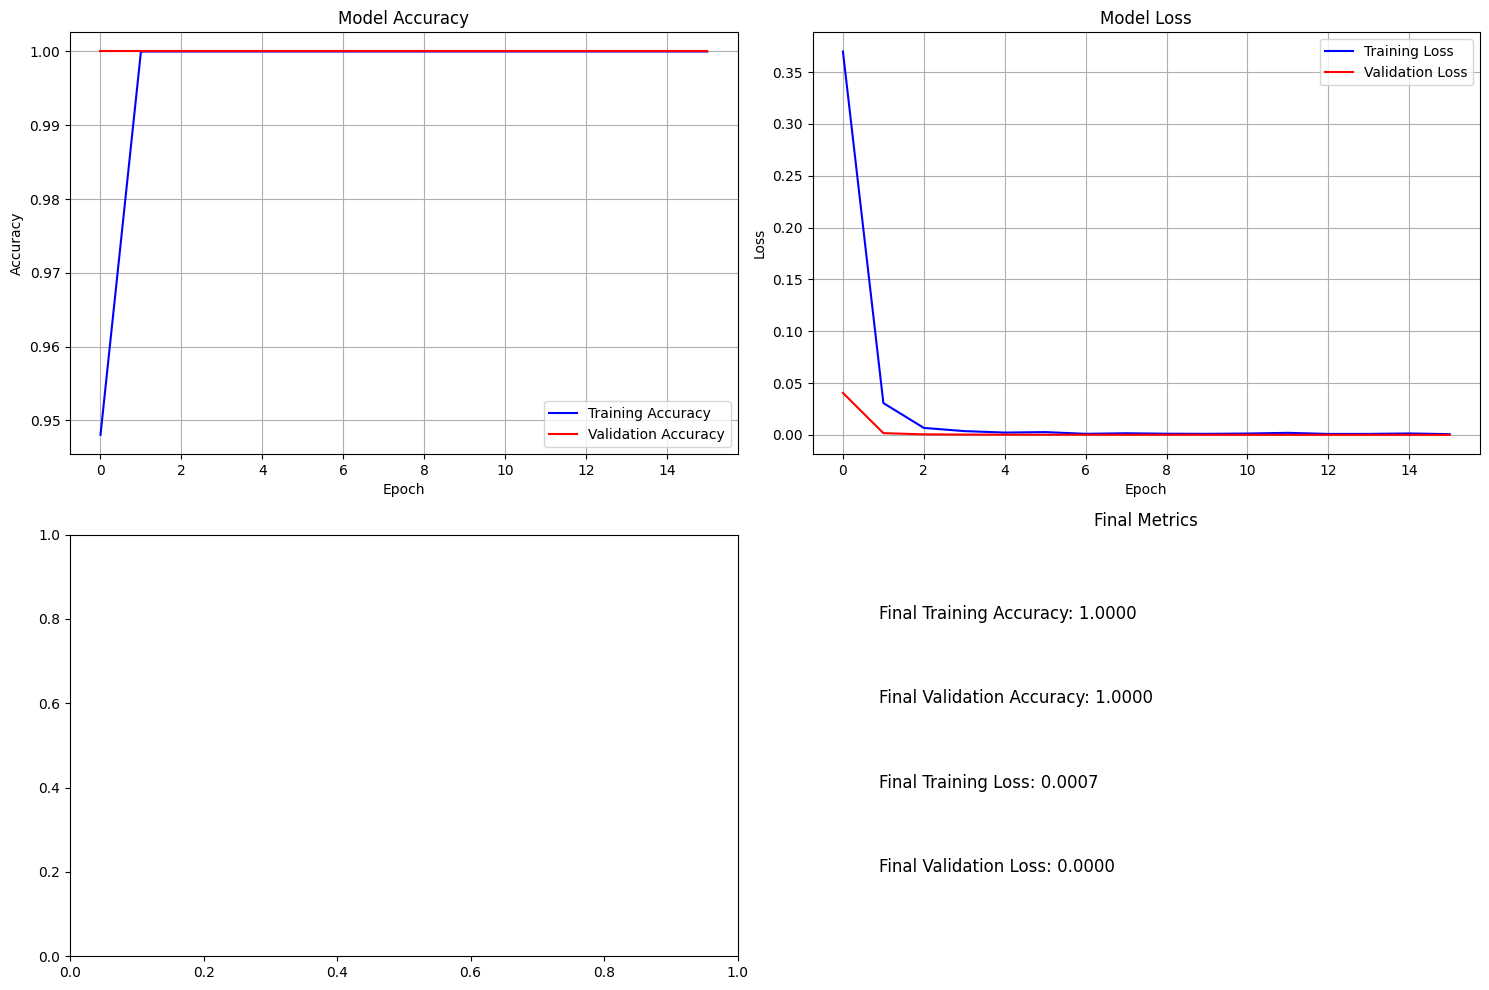


Final Test Results:
Test Loss: 0.0405
Test Accuracy: 1.0000


In [12]:
def plot_training_history(history):
    """
    Plot training history
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss', color='blue')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', color='red')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot learning rate (if available)
    if 'lr' in history.history:
        axes[1, 0].plot(history.history['lr'], color='green')
        axes[1, 0].set_title('Learning Rate')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].grid(True)
    
    # Final metrics summary
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    axes[1, 1].text(0.1, 0.8, f'Final Training Accuracy: {final_train_acc:.4f}', fontsize=12)
    axes[1, 1].text(0.1, 0.6, f'Final Validation Accuracy: {final_val_acc:.4f}', fontsize=12)
    axes[1, 1].text(0.1, 0.4, f'Final Training Loss: {final_train_loss:.4f}', fontsize=12)
    axes[1, 1].text(0.1, 0.2, f'Final Validation Loss: {final_val_loss:.4f}', fontsize=12)
    axes[1, 1].set_title('Final Metrics')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot training results
plot_training_history(history)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


In [21]:
import pyttsx3

# Initialize the TTS engine globally
tts_engine = pyttsx3.init()
tts_engine.setProperty('rate', 150)  # Optional: speech speed
tts_engine.setProperty('volume', 1.0)  # Optional: max volume

last_spoken = ""

def real_time_prediction():
    """
    Real-time gesture recognition using trained model with TTS feedback
    """
    best_model = tf.keras.models.load_model('.models/best_gesture_model.h5')
    cap = cv2.VideoCapture(0)
    sequence_buffer = deque(maxlen=30)

    print("Starting real-time gesture recognition with TTS...")
    print("Press 'q' to quit")

    global last_spoken

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)

        prediction_text = "No hand detected"
        confidence = 0.0

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    frame, hand_landmarks, mp_hands.HAND_CONNECTIONS
                )

                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])

                wrist_x, wrist_y = landmarks[0], landmarks[1]
                normalized_landmarks = landmarks.copy()
                for i in range(0, len(landmarks), 3):
                    normalized_landmarks[i] -= wrist_x
                    normalized_landmarks[i+1] -= wrist_y

                sequence_buffer.append(normalized_landmarks)

                if len(sequence_buffer) == 30:
                    sequence = np.array(list(sequence_buffer))
                    sequence = np.expand_dims(sequence, axis=0)

                    predictions = best_model.predict(sequence, verbose=0)
                    confidence = np.max(predictions)
                    predicted_index = np.argmax(predictions)
                    predicted_gesture = label_encoder.inverse_transform([predicted_index])[0]

                    if confidence > 0.7:
                        prediction_text = f"{predicted_gesture} ({confidence:.2f})"

                        # Speak only if it's a new prediction
                        if predicted_gesture != last_spoken:
                            tts_engine.say(predicted_gesture)
                            tts_engine.runAndWait()
                            last_spoken = predicted_gesture
                    else:
                        prediction_text = "Uncertain"

        # Display prediction on frame
        cv2.putText(frame, f'Prediction: {prediction_text}', 
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame, f'Buffer: {len(sequence_buffer)}/30', 
                    (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

        cv2.imshow('Real-time Gesture Recognition', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


In [22]:
real_time_prediction()

Starting real-time gesture recognition with TTS...
Press 'q' to quit


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Classification Report:
              precision    recall  f1-score   support

    iLoveYou       1.00      1.00      1.00        18
  kuzuzangpo       1.00      1.00      1.00        20
       peace       1.00      1.00      1.00        20

    accuracy                           1.00        58
   macro avg       1.00      1.00      1.00        58
weighted avg       1.00      1.00      1.00        58



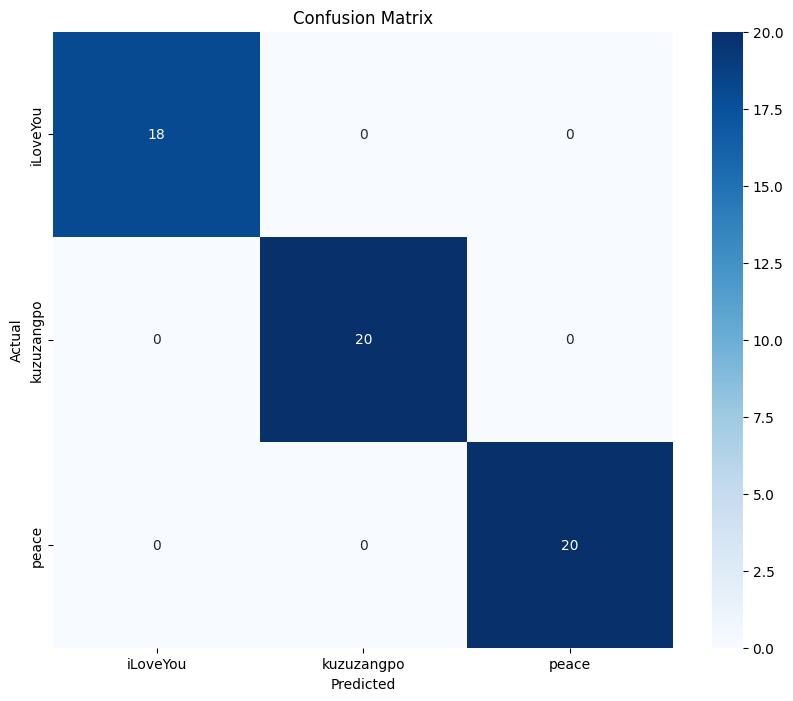

Final model saved as 'final_gesture_model.h5'


In [23]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save final model
model.save('./models/final_gesture_model.h5')
print("Final model saved as 'final_gesture_model.h5'")
